In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
image_dir = '/content/drive/My Drive/cavallo'

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 920


In [ ]:
dataset_array = images.to_pickle()
np.save('dataset.pkl', dataset_array)

AttributeError: 'list' object has no attribute 'to_pickle'

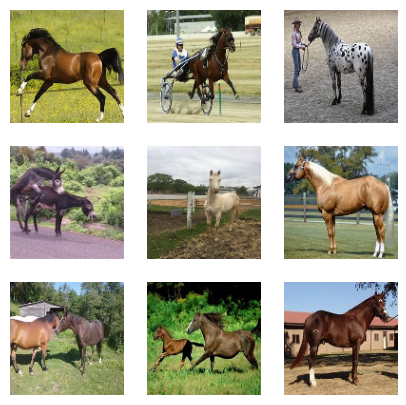

In [ ]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [ ]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3

    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)

    return parts

In [ ]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))

    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())

    return combinations, original_positions

In [ ]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square

    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)

    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]

    return stitched_image

In [ ]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)

    for idx, combination in enumerate(combinations):

        # shape of combination is (9, 40, 40, 3)
        combination = np.array(combination).transpose(0, 3, 1, 2)
        combination = np.concatenate(combination, axis=0).transpose(1, 2, 0)
        input_data.append(combination)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [ ]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 40, 40, 27)
Target data shape: (26230, 81)


In [ ]:
# select random image
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])

target
[[0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0]]
non_converted_target [4, 6, 7, 1, 8, 2, 3, 5, 0]


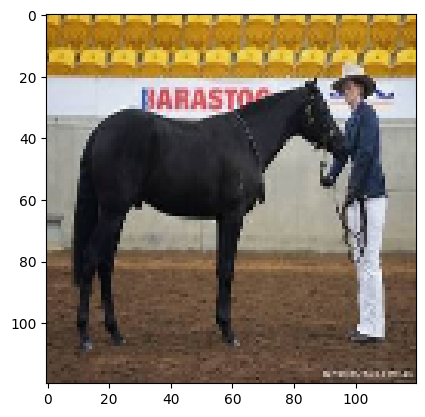

In [ ]:
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data, test=False):

    sequenced = [0] * 9
    for i in range(0,27,3):

        # stack the 3 channels to get the original image
        blue_channel = img[:,:,i]
        green_channel = img[:,:,i+1]
        red_channel = img[:,:,i+2]

        # stack the 3 channels to get the original image
        tile = np.stack((blue_channel, green_channel, red_channel), axis=2)

        if test:
            sequenced[i // 3] = tile
        else:
            sequenced[non_converted_target_data[i // 3]] = tile

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img


reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [ ]:
class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
class JigsawModel(nn.Module):
    def __init__(self):
        super(JigsawModel, self).__init__()
        self.conv1 = nn.Conv2d(27, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 10 * 10, 4096)
        #self.fc1 = nn.Linear(128 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 81)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 128 * 10 * 10)
        #x = x.reshape(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [ ]:
model = JigsawModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10
batch_size = 64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train)
test_dataset = JigsawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
test_dataset = JigsawDataset(X_test, y_test)

# Convert to NumPy array using a method in the class (if available)
dataset_array = test_dataset.to_numpy()

# Save the array to a .npy file
np.save('test_dataset.npy', dataset_array)
dataset_pkl = test_dataset.to_pickle()
np.save('test_dataset.pkl', dataset_pkl)

NameError: name 'JigsawDataset' is not defined

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # cnn input shape is (batch_size, channels, height, width)
        inputs = inputs.permute(0, 3, 1, 2).float()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

ValueError: Expected input batch_size (256) to match target batch_size (64).

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Optionally, change the working directory

print("Directory changed to:", os.getcwd())

# Save the model in the new directory
torch.save(model.state_dict(), 'correctedmodel.pth')

print('Model saved to', os.path.join(os.getcwd(), 'model.pth'))

Current Directory: d:\sem6\DL\dolphin
Directory changed to: d:\sem6\DL\dolphin
Model saved to d:\sem6\DL\dolphin\model.pth


In [ ]:
def recur(sequence, outputs):
    sequence = np.array(sequence)
    for i in range(len(sequence)):
        while np.sum(sequence == sequence[i]) > 1:  # If the current element is a duplicate
            # Find the index in outputs for the current sequence element that is not yet in the updated sequence
            scores = outputs[i]
            sorted_indices = np.argsort(scores)[::-1]  # Indices of scores sorted in descending order
            for idx in sorted_indices:
                if idx not in sequence:
                    sequence[i] = idx
                    break

    return sequence.tolist()

In [ ]:
correct = 0
total = 0
per_tile_accuracy = 0

model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2).float()
        outputs = model(inputs)

        # reshape the output to 9x9 matrix
        outputs = outputs.reshape(-1, 9, 9)
        predicted = torch.argmax(outputs, dim=1)

        # now doing the same for the target
        labels = labels.reshape(-1, 9, 9)
        target = torch.argmax(labels, dim=1)

        # check if the predicted sequence is correct
        for i in range(len(predicted)):
            updated_predicted = recur(predicted[i], outputs[i, : , :].numpy())

            if torch.equal(torch.tensor(updated_predicted), target[i]):
                correct += 1
            total += 1

            per_tile_accuracy += (np.array(updated_predicted) == target[i].numpy()).sum() / 9

print('Accuracy on test images: %d %%' % (100 * correct / total))
print('Per tile accuracy on test images: %d %%' % (100 * per_tile_accuracy / total))

target
[[0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
converted target
[7 2 8 6 1 4 0 3 5]
outputs
tensor([[-0.1387,  0.0717, -0.6526, -0.6705,  2.3328, -0.0036,  0.3341,  0.2778,
          1.5293],
        [-2.6023,  0.5015,  0.1237, -0.2082,  0.5104,  0.2703, -0.3103, -0.2027,
          0.3487],
        [-0.3219,  0.1029,  0.7592, -1.9464, -1.0527,  1.2323, -1.5618,  0.5578,
          1.6466],
        [ 0.5573, -0.5796,  0.2678,  0.7590,  0.8914, -0.1379,  0.3054,  0.0056,
          0.0413],
        [ 0.0038,  1.3235,  1.3759,  0.9394,  0.0732, -0.5453, -0.2778,  0.0832,
         -0.7880],
        [-0.4850,  0.6280, -1.5956, -0.6359,  1.3389, -0.2905,  0.9473, -1.3676,
          0.4683],
        [ 0.2358,  1.7557,  0.6139,  1.3056, -0.4883,  0.1140, -1.1442, -1.8006,
          1.2127],
        [-0.0968, -0.3628,  0.7735,  1.2032, -0.7915,  0.4

Text(0.5, 1.0, 'with predicted sequence')

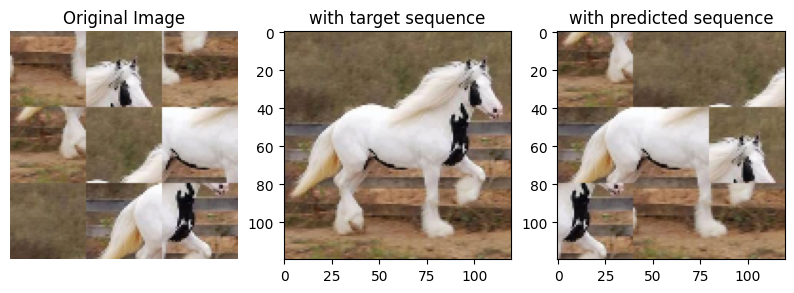

In [ ]:
# select random image from test set
idx = random.randint(0, len(X_test))
image = X_test[idx]
target = y_test[idx]


plt.figure(figsize=(10, 10))
converted_target = np.argmax(target.reshape(9, 9), axis=1)

plt.subplot(131)
plt.imshow(cv2.cvtColor(reconstructed_image(image, converted_target, test=True), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
print("target", target.reshape(9, 9), sep="\n")
print("converted target", converted_target, sep="\n")
reconstructed_img = reconstructed_image(image, converted_target)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with target sequence')

plt.subplot(133)
inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
outputs = model(inputs)
outputs = outputs.reshape(9, 9)
print("outputs", outputs, sep="\n")

predicted = torch.argmax(outputs, dim=1)
print("predicted", predicted, sep="\n")
updated_predicted = recur(predicted, outputs.detach().numpy())
print("updated predicted", updated_predicted, sep="\n")

reconstructed_img = reconstructed_image(image, updated_predicted)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with predicted sequence')

In [ ]:
model = JigsawModel()
model.load_state_dict(torch.load('cnn_ann_model.pth'))
model.eval()
# Set the model to evaluation mode


JigsawModel(
  (conv1): Conv2d(27, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=81, bias=True)
)

In [ ]:
idx = random.randint(0, len(X_test))
image = X_test[idx]
target = y_test[idx]
inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
outputs = model(inputs)
outputs = outputs.reshape(9, 9)
print(outputs)
converted_target = np.argmax(target.reshape(9, 9), axis=1)
print(converted_target)

tensor([[ 2.3782,  1.3637, -0.4413,  0.5571, -2.0462,  0.4586, -0.9831,  1.1946,
          0.1377],
        [ 1.8238,  1.7925,  2.0295,  1.1280, -1.3376, -0.1343, -1.2750, -2.7792,
         -1.7438],
        [ 1.8847,  2.3111,  0.5000, -1.2877, -3.2267, -0.0140,  0.8278,  0.0724,
          0.8302],
        [-0.0981, -2.2014, -0.8123,  1.1570, -0.7898, -0.1121,  3.0562,  1.2854,
          0.9707],
        [-2.3844, -0.0529, -1.3790,  1.8561,  0.9242, -0.6280,  3.6171,  2.5855,
          1.3122],
        [-0.3859, -2.9752, -1.6588,  0.7147,  2.6847, -1.5414, -0.2093,  1.2233,
         -0.8501],
        [ 0.1755,  3.4025,  4.1595, -1.4491, -1.7863,  0.2514, -1.9663, -1.7259,
         -1.4857],
        [-2.2308, -0.5360, -0.1002,  0.3066,  3.1011,  1.4230, -0.4463, -1.1392,
         -2.4572],
        [-1.3142, -2.4695, -2.2635, -0.0331, -1.0481,  1.5937,  1.0164,  2.5805,
          3.1546]], grad_fn=<ReshapeAliasBackward0>)
[3 0 2 8 6 4 1 5 7]


In [ ]:

def process_image(image, model):
    inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    outputs = model(inputs)
    outputs = outputs.reshape(9, 9)
    return outputs

def fix_max_positions(outputs, fixed_positions):
    for i in range(outputs.shape[0]):
        max_index = outputs[i].argmax()
        fixed_positions[i, max_index] = True
    return fixed_positions

def iterative_solve(model, X_test, y_test, i,num_iterations=9):
    idx = i
    image = X_test[idx]
    target = y_test[idx]
    outputs = process_image(image, model)
    print("Initial outputs:")
    print(outputs)

    fixed_positions = np.zeros(outputs.shape, dtype=bool)
    converted_outputs = np.zeros_like(outputs.detach().numpy())  # Modify this line

    for i in range(num_iterations):
        fixed_positions = fix_max_positions(outputs, fixed_positions)
        outputs = process_image(image, model)  # Assuming re-evaluation with fixed positions
        converted_outputs = np.argmax(outputs.detach().numpy(), axis=1)  # Detach before converting

    # Final converted outputs
    final_converted_outputs = np.argmax(outputs.detach().numpy(), axis=1)  # Detach before converting
    converted_target = np.argmax(target.reshape(9, 9), axis=1)
    print(converted_target)

    # Calculate accuracy or comparison metric if desired
    accuracy = np.mean(final_converted_outputs == converted_target)
    #print(f"Accuracy: {accuracy*100:.2f}%")
    return accuracy
l = []
for i in range(len(X_test)):
    accuracy1 = iterative_solve(model, X_test, y_test, i,num_iterations=9)
    l.append(accuracy1)
print(np.mean(l))



In [ ]:
class AlexNetwork(nn.Module):
  def __init__(self,aux_logits = False):
      super(AlexNetwork, self).__init__()
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),

        nn.Conv2d(96, 384, kernel_size=5, stride = 2,padding = 2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),

        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),

        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),

        nn.Conv2d(384, 256, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2,padding = 1),
      )
      self.fc6 = nn.Sequential(
        nn.Linear(256,4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096),
      )
      self.fc = nn.Sequential(
        nn.Linear(2*4096,4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output


  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random



In [ ]:
relative_position_model_path = '/gdrive/My Drive/model_64_65_0.0005_1000_15_3.pt'


In [ ]:
relative_position_model = AlexNetwork()
relative_position_model.load_state_dict(torch.load(relative_position_model_path))
relative_position_model.eval()